In [1]:
import os

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

from sklearn.cluster import DBSCAN
from sklearn.metrics import pairwise_distances
from kneed import KneeLocator

from utils.models import Dataset, SplitDataset

Reading the data and merging it in one pandas dataframe, since we are essentially doing data exploration

In [2]:
train_set_umap = pd.read_csv(os.getenv('train_original_umap_X'), index_col=0)
val_set_umap = pd.read_csv(os.getenv('val_original_umap_X'), index_col=0)
test_set_umap = pd.read_csv(os.getenv('test_original_umap_X'), index_col=0)

train_set_original = pd.read_csv(os.getenv('TRAIN_SET_ORIGINAL_PATH'), index_col=0, header=[0, 1, 2])
val_set = pd.read_csv(os.getenv('VALIDATION_SET_PATH'), index_col=0, header=[0, 1, 2])
test_set = pd.read_csv(os.getenv('TEST_SET_PATH'), index_col=0, header=[0, 1, 2])

genre_column = ('genre', 'Unnamed: 253_level_1', 'Unnamed: 253_level_2')
train_y = train_set_original[genre_column]
val_y = val_set[genre_column]
test_y = test_set[genre_column]

We will not utilize the genre column, since it is subjectvie (assigned by the authors themselves) and may lead to wrong conclusions about the data. In fact it may not even be the case that the genres come up naturally with the clustering.

*A reminder that the UMAP dimensionality reduction was done with min_dist=0.0, which is appropriate for clustering*

In [4]:
print(train_set_umap.shape, val_set_umap.shape, test_set_umap.shape)
print(train_set_original.shape, val_set.shape, test_set.shape)

(21572, 15) (2397, 15) (5993, 15)
(21572, 519) (2397, 519) (5993, 519)


In [8]:
df_umap = pd.concat([train_set_umap, val_set_umap, test_set_umap], axis=0)
df_all = pd.concat([train_set_original, val_set, test_set], axis=0)
df_all.drop(genre_column, inplace=True, axis=1)
df_y = pd.Series(pd.concat([train_y, val_y, test_y], axis=0), name='genre')

print(df_umap.shape, df_all.shape, df_y.shape)

(29962, 15) (29962, 518) (29962,)


In this notebook we will be using the DBSCAN algorithm, and since it is a density based algotighm, it can suffer from the curse of dimensionality, which is the reason why we use the UMAP - reduced dataset.
The algorithm is approrpiate in our case since it does not make assumptions about the shapes of the clusters.
About the hyperparameters, *MinPts* should generally be greater than or equal to the dimensionality of the data set, so In our case we could try using *MinPts=100*.

About the choice of $\epsilon$, we will calcualte the average distance between each point and it's 100 (*MinPts*) nearest neighbors. We will then plot these distances in ascending order and choose the value for $\epsilon$ that is at the point of maximum curvature on the plot (i.e. where the graph has the greatest slope-knee)


# Parameter Choosing

In [9]:
MIN_SAMPLES = 100

In [10]:
def calculate_distances(X, metric):
    return pd.DataFrame(pairwise_distances(X, metric=metric, n_jobs=5), index=X.index, columns=X.index)

In [11]:
df_distances = calculate_distances(df_umap, 'euclidean')

In [12]:
top_min_samples_closest_df = pd.DataFrame(df_distances.apply(lambda row: row.nsmallest(MIN_SAMPLES).values, axis=1).tolist())

In [13]:
mean_distances = top_min_samples_closest_df.mean(axis=1).sort_values(ascending=True)

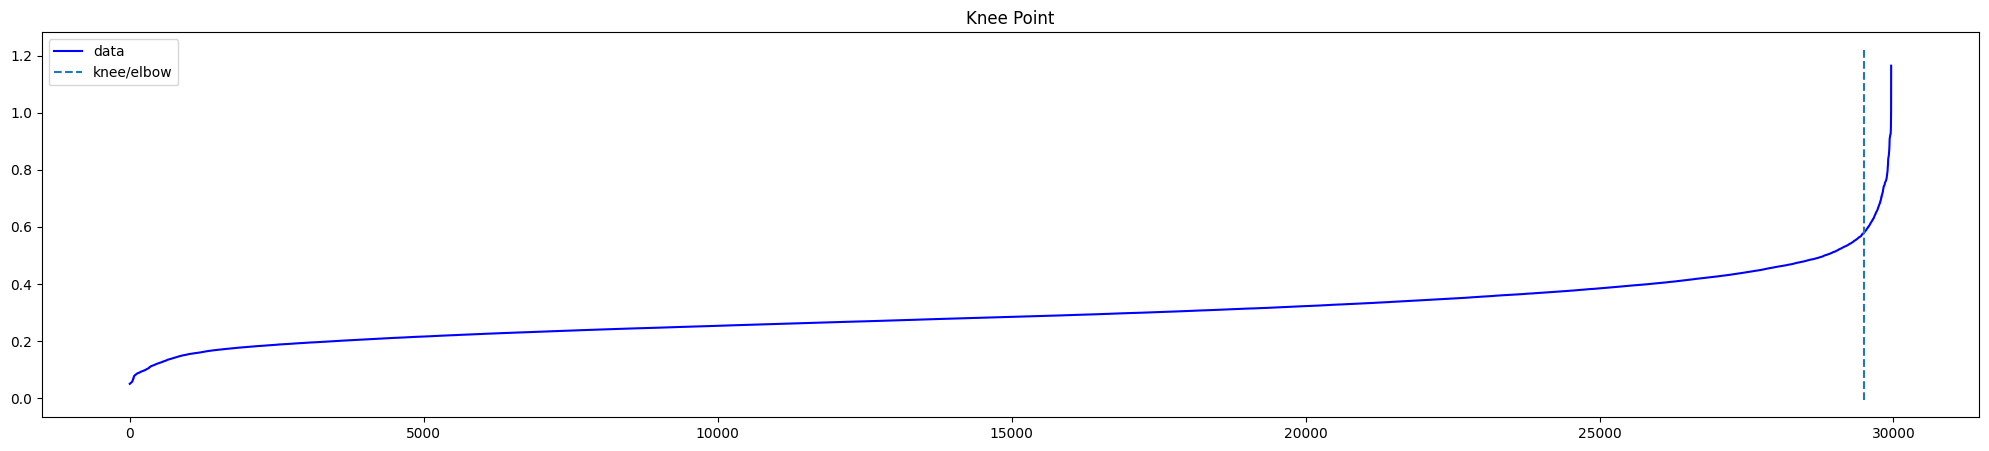

In [89]:
kl = KneeLocator(range(len(mean_distances)), mean_distances, curve="convex")
kl.plot_knee(figsize=(25, 5))

In [15]:
epsilon = kl.elbow_y

In [16]:
epsilon

0.5784428556686668

# Clustering

In [46]:
dbscan = DBSCAN(eps=epsilon-0.25, min_samples=MIN_SAMPLES, metric='euclidean')

In [47]:
dbscan.fit(df_umap)

DBSCAN(eps=0.3284428556686668, min_samples=100)

In [48]:
clusters = pd.Series(dbscan.labels_, index=df_umap.index, name='cluster')

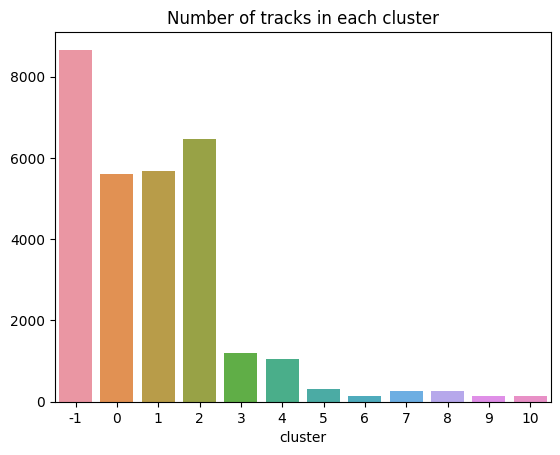

In [49]:
plt.figure()
sns.barplot(x=clusters.value_counts().index, y=clusters.value_counts().values)
plt.title('Number of tracks in each cluster')
plt.show()

In [50]:
df_complete = pd.concat([
    df_umap,
    df_y,
    clusters
], axis=1)

In [51]:
cluster_by_genre = df_complete.groupby(['genre', 'cluster']).size().reset_index(name='count')

In [52]:
cluster_by_genre.index = pd.MultiIndex.from_tuples(sorted(list(set(zip(cluster_by_genre['genre'], cluster_by_genre['cluster'])))), names=['Genre', 'Cluster'])

In [53]:
cluster_by_genre_pivoted = cluster_by_genre.pivot_table(index='Cluster', columns='Genre', values='count').fillna(0)
cluster_by_genre_pivoted

Genre    Blues  Classical  Country  Easy Listening  Electronic  Experimental  \
Cluster                                                                        
-1        42.0       67.0     43.0             4.0      2475.0        1346.0   
 0        33.0      587.0     37.0             3.0       426.0         776.0   
 1        12.0       13.0      8.0             9.0      2562.0         538.0   
 2         9.0       10.0     40.0             0.0       533.0         671.0   
 3         2.0        1.0      0.0             1.0       821.0         101.0   
 4         2.0        0.0     16.0             0.0        79.0          80.0   
 5         0.0        2.0      1.0             0.0        71.0          67.0   
 6         0.0       73.0      0.0             0.0         4.0          44.0   
 7         0.0        0.0      0.0             0.0        88.0          13.0   
 8         1.0        3.0      3.0             1.0        47.0          25.0   
 9         1.0        0.0      0.0             0.0        50.0          35.0   
 10        0.0        1.0      0.0             3.0        48.0          25.0   

Genre      Folk  Hip-Hop  Instrumental  International   Jazz  \
Cluster                                                        
-1        461.0    791.0         463.0          221.0  140.0   
 0       1233.0     48.0         612.0          262.0  192.0   
 1         51.0   1443.0          99.0          248.0   33.0   
 2         86.0    266.0         172.0           49.0   30.0   
 3         13.0     23.0          14.0           27.0    8.0   
 4         20.0     21.0          22.0            4.0    8.0   
 5         15.0     14.0          24.0           13.0    2.0   
 6          4.0      0.0           2.0            0.0    0.0   
 7          3.0    118.0           1.0            7.0    0.0   
 8         26.0      6.0          94.0            4.0   10.0   
 9          1.0      3.0           6.0           10.0    1.0   
 10         4.0     11.0          20.0            1.0    0.0   

Genre    Old-Time / Historic    Pop    Rock  Soul-RnB  Spoken  
Cluster                                                        
-1                       8.0  462.0  2062.0      52.0    29.0  
 0                     434.0  294.0   641.0       6.0    31.0  
 1                       0.0  268.0   253.0      66.0    88.0  
 2                       3.0  250.0  4320.0      12.0     6.0  
 3                       0.0   30.0   144.0       7.0     6.0  
 4                       0.0   74.0   724.0       7.0     3.0  
 5                       0.0   12.0    94.0       0.0     1.0  
 6                      12.0    0.0     7.0       0.0     0.0  
 7                       0.0    6.0    26.0       0.0     0.0  
 8                       0.0   20.0    30.0       2.0     0.0  
 9                       0.0   13.0    27.0       0.0     0.0  
 10                      0.0    3.0    16.0       0.0     0.0

In [54]:
cluster_by_genre_pivoted_scaled = (cluster_by_genre_pivoted.divide(cluster_by_genre_pivoted.sum(), axis=1) * 100).round(2)

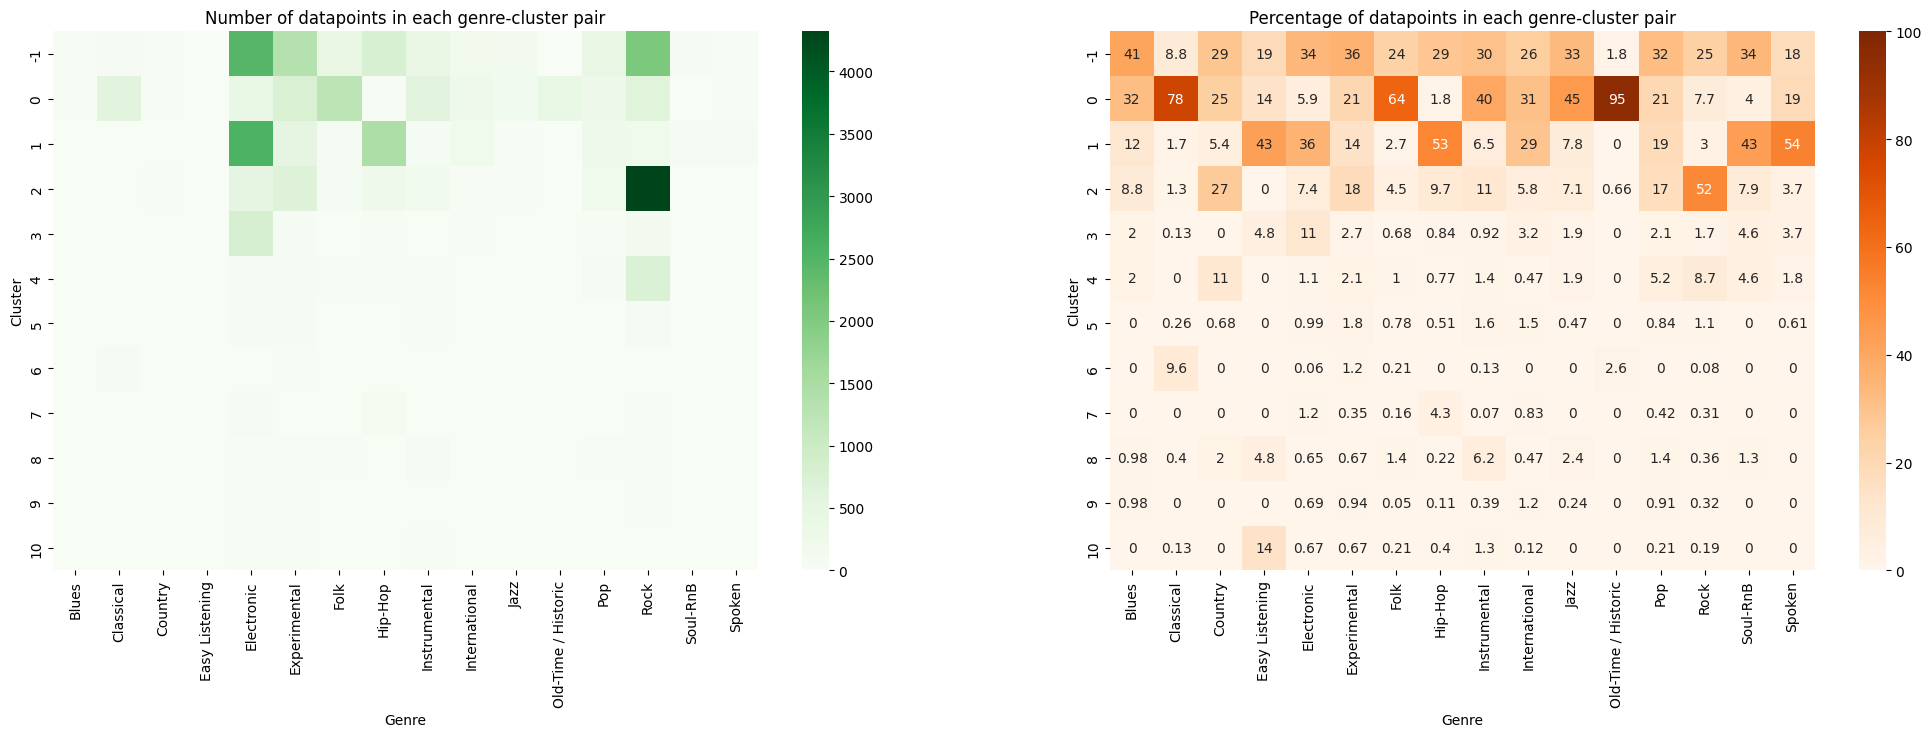

In [55]:
fig, axs = plt.subplots(1, 2, figsize=(25, 7))
sns.heatmap(cluster_by_genre_pivoted, annot=False, cmap='Greens', ax=axs[0])
sns.heatmap(cluster_by_genre_pivoted_scaled, annot=True, cmap='Oranges', ax=axs[1], vmin=0, vmax=100)
axs[0].set_title('Number of datapoints in each genre-cluster pair')
axs[1].set_title('Percentage of datapoints in each genre-cluster pair')
plt.show()

In [56]:
cluster_by_genre_no_idx = cluster_by_genre.reset_index(drop=True)
fist_half = cluster_by_genre_no_idx[cluster_by_genre_no_idx.genre.isin(['Blues', 'Classical', 'Country', 'Easy Listening', 'Electronic', 'Experimental', 'Folk', 'Hip-Hop'])]
second_half = cluster_by_genre_no_idx[cluster_by_genre_no_idx.genre.isin(['Instrumental', 'Jazz', 'Old-Time / Historic', 'Pop', 'Rock', 'Soul-RnB', 'Spoken'])]

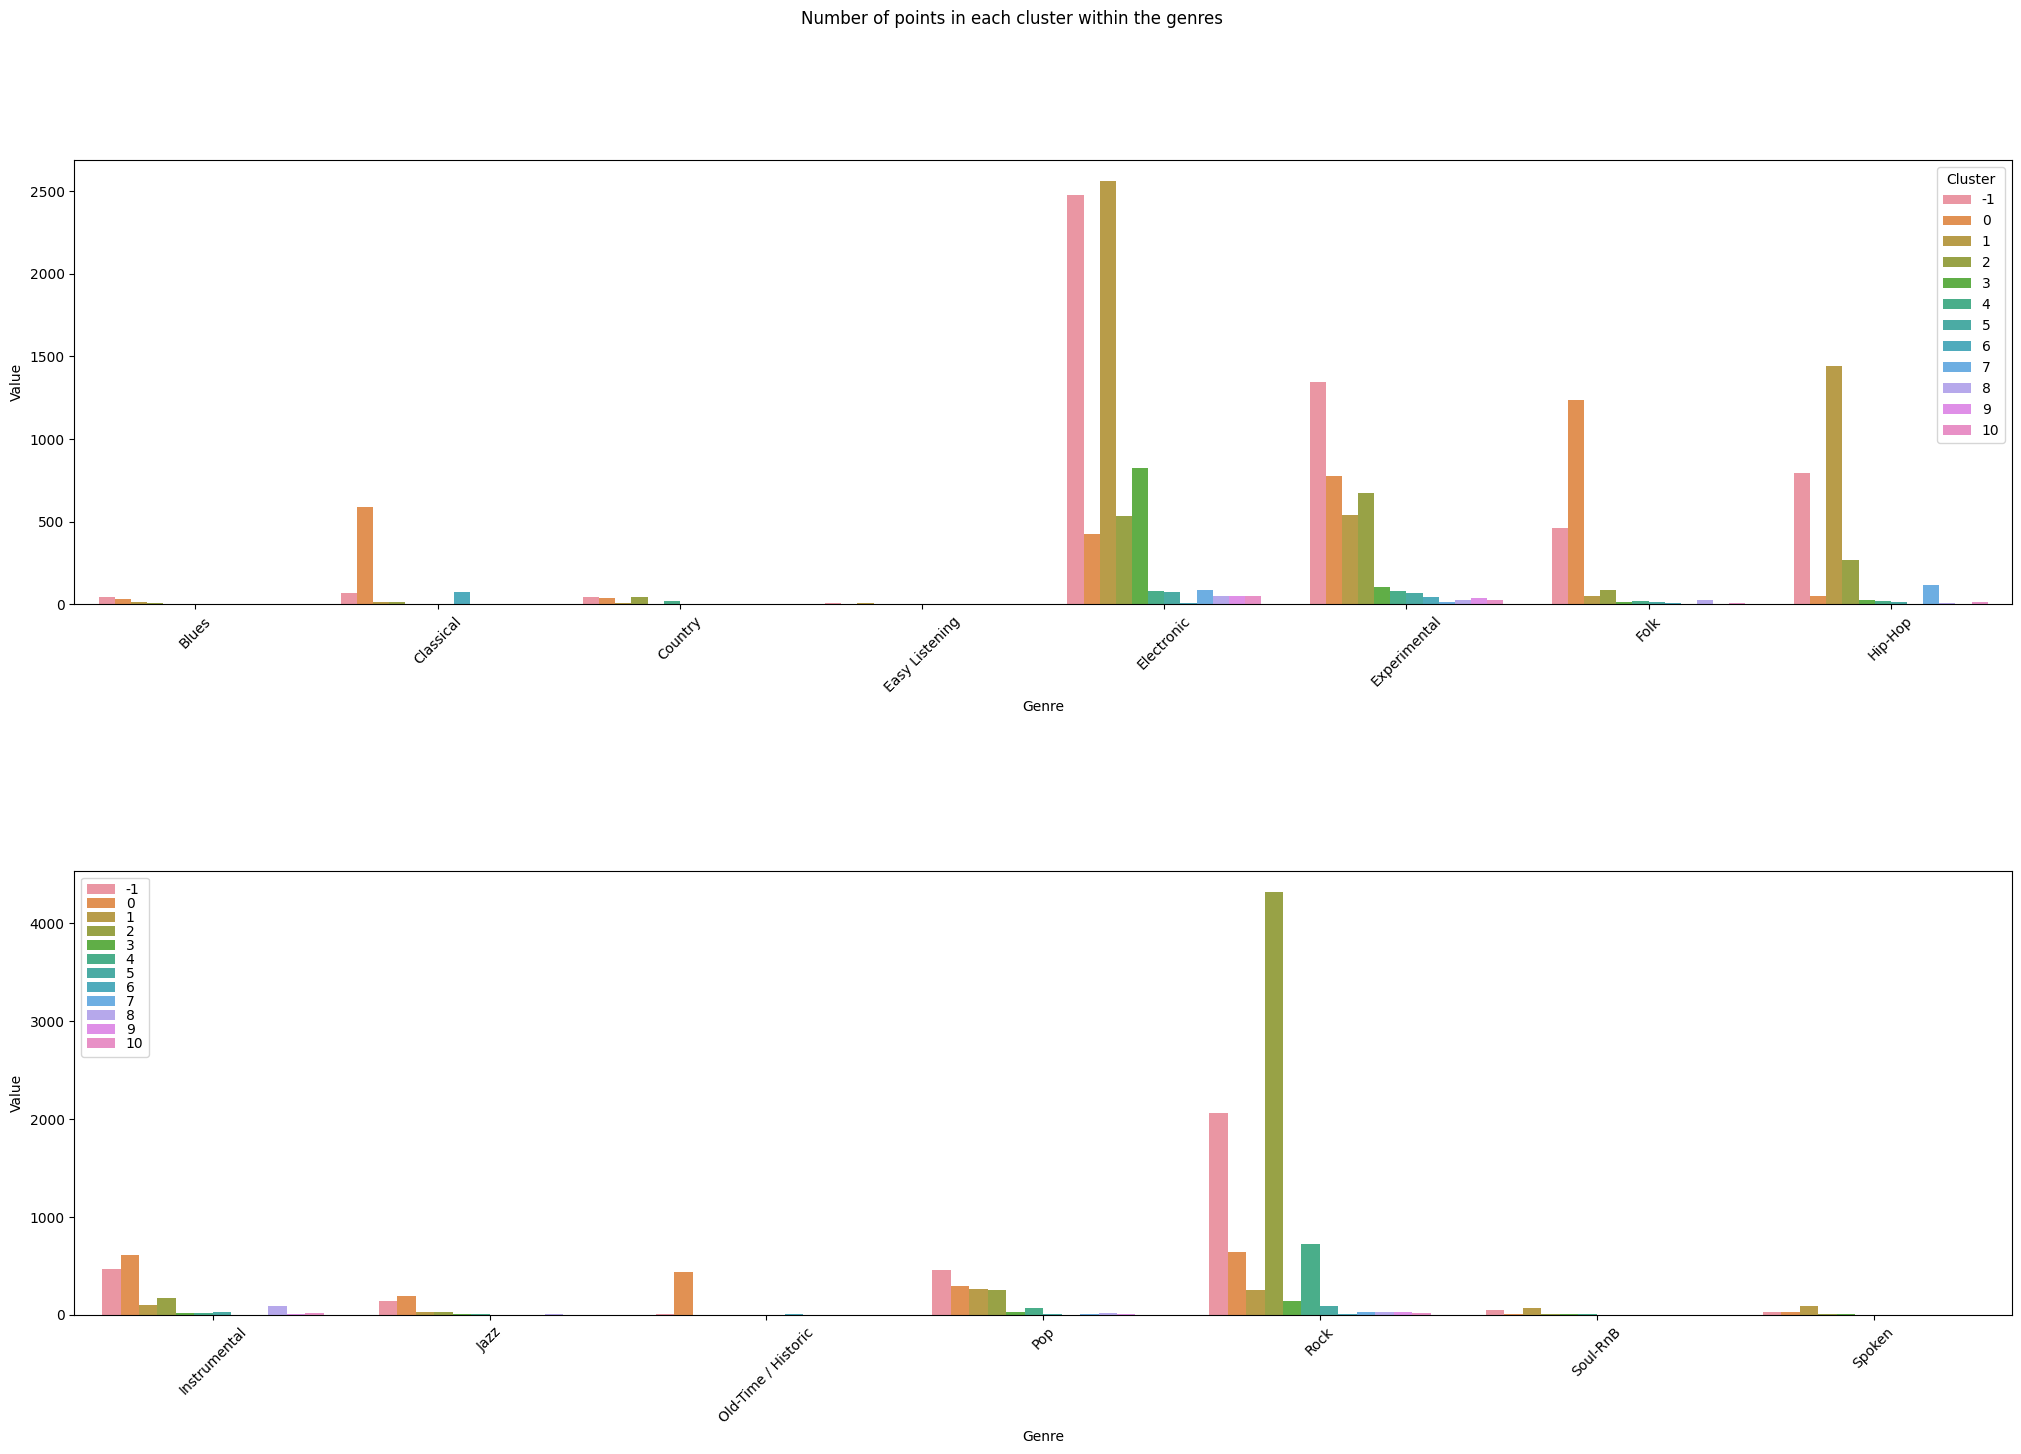

In [57]:
fig, axs = plt.subplots(2, 1, figsize=(25, 15),)
sns.barplot(x='genre', y='count', hue='cluster', data=fist_half, ax=axs[0])
axs[0].set_xlabel('Genre')
axs[0].set_ylabel('Value')
axs[0].tick_params(axis='x', rotation=45)
axs[0].legend(title='Cluster')

sns.barplot(x='genre', y='count', hue='cluster', data=second_half, ax=axs[1])
axs[1].set_xlabel('Genre')
axs[1].set_ylabel('Value')
axs[1].tick_params(axis='x', rotation=45)
axs[1].legend(labelspacing=0) 

fig.suptitle('Number of points in each cluster within the genres')

plt.subplots_adjust(hspace=0.6)
plt.show()

In [58]:
import utils.visualization_utils as vis_utils

In [84]:
df_all_clusters = pd.concat([df_all, clusters.astype('str')], axis=1)

In [85]:
vis_utils.genre_3d_umap_visualization(
    df=df_all_clusters, label_column='cluster', 
    n_components = 3, n_neighbors=50, 
    min_dist=0.1, metric='cosine',
    features=[c for c in df_all_clusters.columns if 'mfcc' in c[0] or 'spectral_contrast' in c[0]],
    output_file='dbscan_clustering.html'
)